# Model Comparison: RF vs SVM vs KNN vs Logistic Regression

Cross-model evaluation built from the final SVM (3a_SVM_MVELLA), Random Forest (3b_RF_ISAAC_CUTAJAR), KNN (3c_KNN_MMIZZI), and Logistic Regression (3d_logistic_regression_PAUL_SAID) notebooks.

## Goals
- Load the shared dataset and recreate all four pipelines (RF, SVM-RBF, KNN, Logistic Regression)
- Produce a single metrics table (ROC-AUC, accuracy, precision, recall, F1)
- Run significance tests on paired predictions
- Visualise ROC curves, metric comparisons, and feature importance
- Summarise trade-offs: accuracy vs interpretability, complexity vs performance, training vs prediction speed

## 2. Setup and Data Preparation

### 2.1 Import libraries- Machine learning (sklearn classifiers and evaluation tools)


In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.inspection import permutation_importance
from scipy.stats import chi2
RANDOM_STATE = 42
rng = np.random.default_rng(42)
sns.set_theme(style="whitegrid")

### 2.2 Load Data

**What we're doing:** Loading the same cleaned accident dataset used in the individual notebooks and applying the same transformations

In [36]:
# Load data and derive target
df = pd.read_csv('../../data/final/data_post_eda.csv')
bool_cols = df.select_dtypes(include=['bool']).columns
if len(bool_cols) > 0:
    df[bool_cols] = df[bool_cols].astype(int)

def map_severity(sev):
    non_fatal = ['not injured', 'slight', 'grievious', 'serious']
    fatal = ['fatal']
    if sev in non_fatal:
        return 0
    if sev in fatal:
        return 1
    return np.nan

df['is_fatal'] = df['accident_severity'].apply(map_severity)
df = df.dropna(subset=['is_fatal']).copy()
df['is_fatal'] = df['is_fatal'].astype(int)
print(f"Dataset: {df.shape[0]} rows, {df.shape[1]} columns")
print(df['is_fatal'].value_counts())

Dataset: 211 rows, 59 columns
is_fatal
0    183
1     28
Name: count, dtype: int64


### 2.3 Feature Selection

Using the same set of features for all model, based on the EDA:

**Our feature set includes:**
- **3 Categorical features:** region, street_type, accident_time_category (text categories that get converted to numbers)
- **17 Numerical features:** driver demographics, vehicle counts, weather, date info

**Important:** All models use the exact same features for fair comparison.

**Feature selection:** After evaluating the findings of the EDA and performing feature importance analysis at a model level, multiple features including the following features: 'num_drivers_age_unknown', 'num_drivers_gender_unknown', 'num_vehicle_bus' were excluded from model training.  We also tried both feature sets out and after evaluating the results, lower accuracy was achieved when including the aforementioned features results. Accuracy was determine by analysing the ROC curve + a detailed metrics comparison. To conclude these features primarily reflected reporting uncertainty rather than accident characteristics and introduced noise into the learning process, thus why they were left out from the final feature set.

In [37]:
# Feature set (aligned with RF notebook to keep parity across models)
cat_cols = ['region', 'street_type', 'accident_time_category']
num_cols = [
    'num_drivers_under_18',
    'num_drivers_18_to_24',
    'num_drivers_25_to_49',
    'num_drivers_50_to_64',
    'num_drivers_65_plus',
    'num_drivers_male',
    'num_drivers_female',
    'num_vehicle_unknown',
    'num_vehicle_pedestrian',
    'num_vehicle_bicycle',
    'num_vehicle_motorbike',
    'num_vehicle_car',
    'num_vehicle_van',
    'is_weekend',
    'is_school_holiday_mt',
    'temperature_mean',
    'is_raining'
]
X = df[cat_cols + num_cols].copy()
y = df['is_fatal']
print(f"Features: {X.shape[1]} columns; Target positive rate: {y.mean():.3f}")

Features: 20 columns; Target positive rate: 0.133


## 3. Pipeline Architecture

**Key Design Principle:** Each model is wrapped in a scikit-learn Pipeline (preprocessing + classifier) to ensure clean reproducability and fair comparison.

**Pipeline Structure:**
- **RandomForest Pipeline:** Preprocessing (no scaling)
- **SVM/LNN/LogisticRegression Pipelines:** Preprocessing (with StandardScaler)

All models use identical:
- Feature set (23 columns: 3 categorical + 19 numerical)
- CV strategy (StratifiedKFold, n_splits=5, random_state=42)
- Train/test split (80/20, stratified, random_state=42)
- Evaluation metrics (ROC-AUC, accuracy, precision, recall, F1)

### 3.1 Preprocessing Pipelines

 **SVM:** Needs scaling because it's sensitive to feature magnitudes

 **KNN:** Needs scaling because it uses distance metrics

 **Logistic Regression:** Needs scaling for better convergence and interpretable coefficients

 **Random Forest:** Doesn't need scaling (tree-based algorithm)

In [38]:
# Preprocessing blocks for all the models
cat_ohe = Pipeline([
    ('imp', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

num_med = Pipeline([
    ('imp', SimpleImputer(strategy='median'))
])

num_scaled = Pipeline([
    ('imp', SimpleImputer(strategy='median')),
    ('sc', StandardScaler())
])

preprocess_rf = ColumnTransformer([
    ('cat', cat_ohe, cat_cols),
    ('num', num_med, num_cols)
])

preprocess_svm = ColumnTransformer([
    ('cat', cat_ohe, cat_cols),
    ('num', num_scaled, num_cols)
])

preprocess_knn = ColumnTransformer([    
    ('num', num_scaled, num_cols),
    ('cat', cat_ohe, cat_cols),
])

preprocess_logreg = ColumnTransformer([    
    ('num', num_scaled, num_cols),
    ('cat', cat_ohe, cat_cols)
])

### 3.2 Complete Model Pipelines

Each pipeline combines preprocessing + classifier as a single estimator.

In [39]:
# Models from the four individual notebooks (hyperparameters kept the same )
rf_model = Pipeline([
    ('prep', preprocess_rf),
    ('rf', RandomForestClassifier(
        n_estimators=300,
        class_weight={0: 1, 1: 3},
        n_jobs=-1,
        max_depth=20,
        min_samples_leaf=1,
        min_samples_split=2,
        max_features=0.5,
        max_samples=1.0,
        random_state=RANDOM_STATE
    ))
])

svm_model = Pipeline([
    ('prep', preprocess_svm),
    ('svm', SVC(C=10, kernel='rbf', probability=True, random_state=RANDOM_STATE))
])

knn_model = Pipeline([
    ('prep', preprocess_knn),
    ('knn', KNeighborsClassifier(n_neighbors=7, metric='euclidean'))
])

logreg_model = Pipeline([
    ('prep', preprocess_logreg),
    ('logreg', LogisticRegression(
        class_weight="balanced", 
        solver="liblinear", 
        max_iter=5000, 
        random_state=RANDOM_STATE
    ))
])


models = OrderedDict([    
    ('KNN', knn_model),    
    ('LogisticRegression', logreg_model),
    ('RandomForest', rf_model),        
    ('SVM_RBF', svm_model)
])

## 4. Model Evaluation

### 4.1 Hold-Out Test Set

**Split:** 80% training, 20% validation (stratified to maintain class balance)

**Purpose:** Create a single validation set that both models are tested on. This allows us to:

1. Directly compare predictions on the same samples3. Generate confusion matrices and ROC curves
2. Run statistical significance tests

In [40]:
# Hold-out set for paired significance tests and plots
# Split data: 80% train, 20% validation
# stratify=y maintains same fatal/non-fatal ratio in both sets
# random_state=42 ensures reproducibility and same split for both models
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Store predictions for both models on the SAME validation set
val_preds = {}   # Hard predictions (0 or 1) using default 0.5 threshold
val_probas = {}  # Probability scores (0.0 to 1.0) for positive class (fatal)

# Train each model and generate predictions on validation set
for name, model in models.items():
    # Fit the entire pipeline (preprocessing + classifier) on training data
    fitted = model.fit(X_train, y_train)
    
    # Get hard predictions (0=non-fatal, 1=fatal) using 0.5 threshold
    val_preds[name] = fitted.predict(X_val)
    
    # Get probability of fatal class (column 1) for ROC curves and custom thresholds
    val_probas[name] = fitted.predict_proba(X_val)[:, 1]

# Print average positive prediction rate for each model
print({k: v.mean() for k, v in val_preds.items()})

{'KNN': np.float64(0.023255813953488372), 'LogisticRegression': np.float64(0.4186046511627907), 'RandomForest': np.float64(0.046511627906976744), 'SVM_RBF': np.float64(0.09302325581395349)}


### 4.2 Confusion Matrices (Default Threshold = 0.5)

**What is a confusion matrix?** A table showing how many predictions were correct vs incorrect:
- **TP (True Positive):** Correctly predicted fatal
- **TN (True Negative):** Correctly predicted non-fatal
- **FP (False Positive):** Predicted fatal but was actually non-fatal (false alarm)
- **FN (False Negative):** Predicted non-fatal but was actually fatal (missed detection)

**Threshold 0.5 means:** If the model thinks there's >50% chance of fatality, predict "fatal".

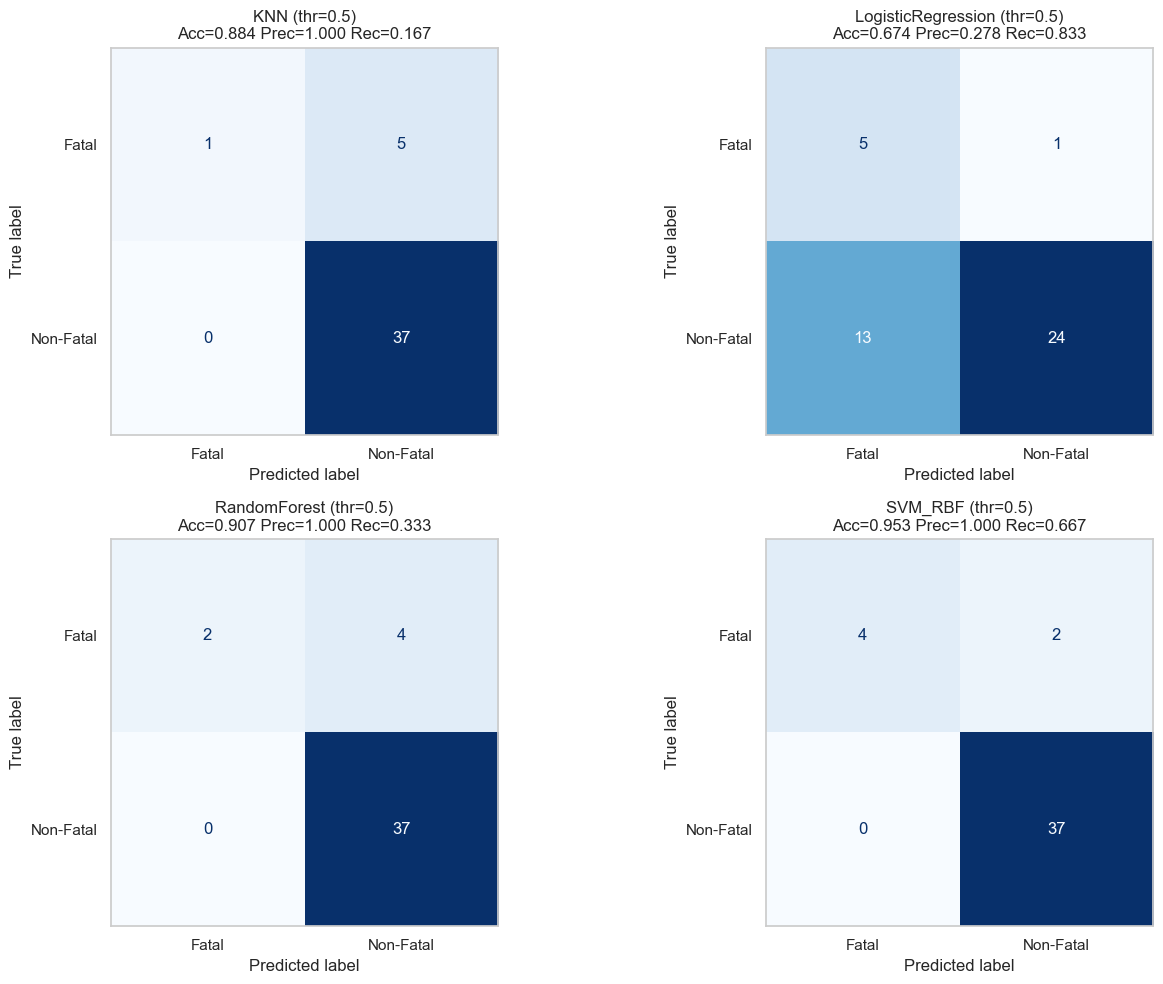


Default 0.5 threshold metrics:
KNN: TP=1, FP=0, FN=5, TN=37
LogisticRegression: TP=5, FP=13, FN=1, TN=24
RandomForest: TP=2, FP=0, FN=4, TN=37
SVM_RBF: TP=4, FP=0, FN=2, TN=37


In [41]:
# Confusion matrices on the hold-out split for all four models (default 0.5 threshold)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
for ax, (name, preds) in zip(axes.flat, val_preds.items()):
    cm = confusion_matrix(y_val, preds, labels=[1, 0])  # [positive, negative]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fatal', 'Non-Fatal'])
    disp.plot(ax=ax, cmap='Blues', colorbar=False, values_format='d')
    ax.grid(False)
    
    # Calculate metrics
    tn, fp, fn, tp = cm[1, 1], cm[1, 0], cm[0, 1], cm[0, 0]
    acc = (tp + tn) / (tp + tn + fp + fn)
    prec = tp / (tp + fp) if (tp + fp) > 0 else 0
    rec = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0
    
    ax.set_title(f"{name} (thr=0.5)\nAcc={acc:.3f} Prec={prec:.3f} Rec={rec:.3f}")
plt.tight_layout()
plt.show()

print("\nDefault 0.5 threshold metrics:")
for name in val_preds.keys():
    cm = confusion_matrix(y_val, val_preds[name], labels=[1, 0])
    tn, fp, fn, tp = cm[1, 1], cm[1, 0], cm[0, 1], cm[0, 0]
    print(f"{name}: TP={tp}, FP={fp}, FN={fn}, TN={tn}")

### 4.3 Confusion Matrices (Custom Threshold = 0.3)

**Why change the threshold?** Lower threshold (0.3 instead of 0.5) means:
- Model predicts "fatal" more often
- Higher recall (catches more actual fatal cases)
- Lower precision (more false alarms)

**Use case:** In safety applications, missing a fatal accident (FN) is worse than a false alarm (FP), so we lower the threshold to catch more fatalities.

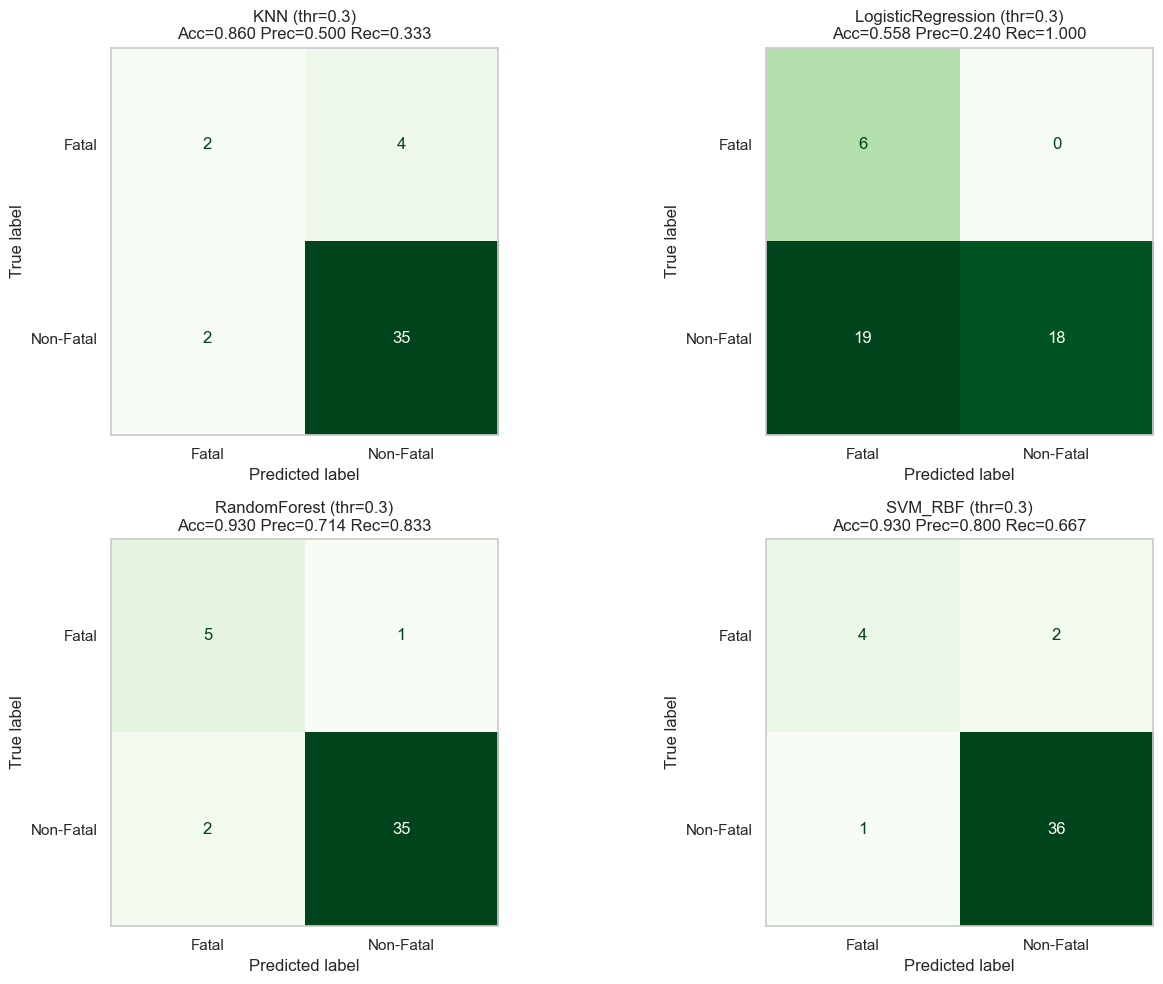


Custom 0.3 threshold metrics (matches RF notebook approach):
KNN: TP=2, FP=2, FN=4, TN=35
LogisticRegression: TP=6, FP=19, FN=0, TN=18
RandomForest: TP=5, FP=2, FN=1, TN=35
SVM_RBF: TP=4, FP=1, FN=2, TN=36


In [42]:
# Confusion matrices with custom 0.3 threshold (matching RF notebook approach)
CUSTOM_THRESHOLD = 0.3
val_preds_custom = {}
for name, probs in val_probas.items():
    val_preds_custom[name] = (probs >= CUSTOM_THRESHOLD).astype(int)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
for ax, (name, preds) in zip(axes.flat, val_preds_custom.items()):
    cm = confusion_matrix(y_val, preds, labels=[1, 0])  # [positive, negative]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fatal', 'Non-Fatal'])
    disp.plot(ax=ax, cmap='Greens', colorbar=False, values_format='d')
    ax.grid(False)
    
    # Calculate metrics
    tn, fp, fn, tp = cm[1, 1], cm[1, 0], cm[0, 1], cm[0, 0]
    acc = (tp + tn) / (tp + tn + fp + fn)
    prec = tp / (tp + fp) if (tp + fp) > 0 else 0
    rec = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0
    
    ax.set_title(f"{name} (thr=0.3)\nAcc={acc:.3f} Prec={prec:.3f} Rec={rec:.3f}")
plt.tight_layout()
plt.show()

print(f"\nCustom {CUSTOM_THRESHOLD} threshold metrics (matches RF notebook approach):")
for name in val_preds_custom.keys():
    cm = confusion_matrix(y_val, val_preds_custom[name], labels=[1, 0])
    tn, fp, fn, tp = cm[1, 1], cm[1, 0], cm[0, 1], cm[0, 0]
    print(f"{name}: TP={tp}, FP={fp}, FN={fn}, TN={tn}")

### 4.4 Detailed Metrics Comparison

**Key metrics explained:**
- **Accuracy:** Overall correctness (TP + TN) / Total
- **Precision:** Of all "fatal" predictions, how many were correct? TP / (TP + FP)
- **Recall (Sensitivity):** Of all actual fatals, how many did we catch? TP / (TP + FN)
- **Specificity:** Of all actual non-fatals, how many did we correctly identify? TN / (TN + FP)
- **F1 Score:** Balance between precision and recall (harmonic mean)

**Trade-off:** High recall = catch more fatalities but more false alarms. High precision = fewer false alarms but miss some fatalities.

In [43]:
# Detailed metrics breakdown for both models at both thresholds
print("="*70)
print("DETAILED METRICS COMPARISON")
print("="*70)

for threshold_name, preds_dict in [("Default (0.5)", val_preds), ("Custom (0.3)", val_preds_custom)]:
    print(f"\n{'='*70}")
    print(f"THRESHOLD: {threshold_name}")
    print(f"{'='*70}")
    
    for name, preds in preds_dict.items():
        cm = confusion_matrix(y_val, preds, labels=[1, 0])
        tn, fp, fn, tp = cm[1, 1], cm[1, 0], cm[0, 1], cm[0, 0]
        
        classification_accuracy = (tp + tn) / float(tp + tn + fp + fn)
        classification_error = (fp + fn) / float(tp + tn + fp + fn)
        precision = tp / float(tp + fp) if (tp + fp) > 0 else 0
        recall = tp / float(tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        print(f"\n{name}:")
        print(f"  TP={tp}, FP={fp}, FN={fn}, TN={tn}")
        print(f"  Classification accuracy : {classification_accuracy:.4f}")
        print(f"  Classification error   : {classification_error:.4f}")
        print(f"  Precision             : {precision:.4f}")
        print(f"  Recall (Sensitivity)  : {recall:.4f}")
        print(f"  Specificity           : {specificity:.4f}")
        print(f"  F1 Score              : {f1:.4f}")

DETAILED METRICS COMPARISON

THRESHOLD: Default (0.5)

KNN:
  TP=1, FP=0, FN=5, TN=37
  Classification accuracy : 0.8837
  Classification error   : 0.1163
  Precision             : 1.0000
  Recall (Sensitivity)  : 0.1667
  Specificity           : 1.0000
  F1 Score              : 0.2857

LogisticRegression:
  TP=5, FP=13, FN=1, TN=24
  Classification accuracy : 0.6744
  Classification error   : 0.3256
  Precision             : 0.2778
  Recall (Sensitivity)  : 0.8333
  Specificity           : 0.6486
  F1 Score              : 0.4167

RandomForest:
  TP=2, FP=0, FN=4, TN=37
  Classification accuracy : 0.9070
  Classification error   : 0.0930
  Precision             : 1.0000
  Recall (Sensitivity)  : 0.3333
  Specificity           : 1.0000
  F1 Score              : 0.5000

SVM_RBF:
  TP=4, FP=0, FN=2, TN=37
  Classification accuracy : 0.9535
  Classification error   : 0.0465
  Precision             : 1.0000
  Recall (Sensitivity)  : 0.6667
  Specificity           : 1.0000
  F1 Score        

### 4.5 ROC Curves

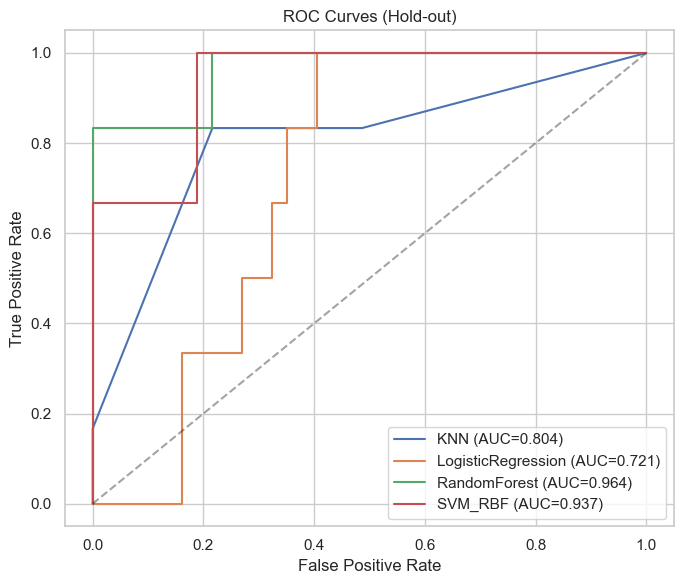

In [44]:
# ROC curves on the shared hold-out split
fig, ax = plt.subplots(figsize=(7, 6))
for name, probs in val_probas.items():
    fpr, tpr, _ = roc_curve(y_val, probs)
    auc = roc_auc_score(y_val, probs)
    ax.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
ax.plot([0, 1], [0, 1], 'k--', alpha=0.4)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves (Hold-out)')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

### 4.6 Visual Metrics Comparison

**What this shows:** Side-by-side comparison of all four models across 5 metrics computed from the hold-out test set (default 0.5 threshold).

**Interpretation:** Taller bars = better performance for that metric.

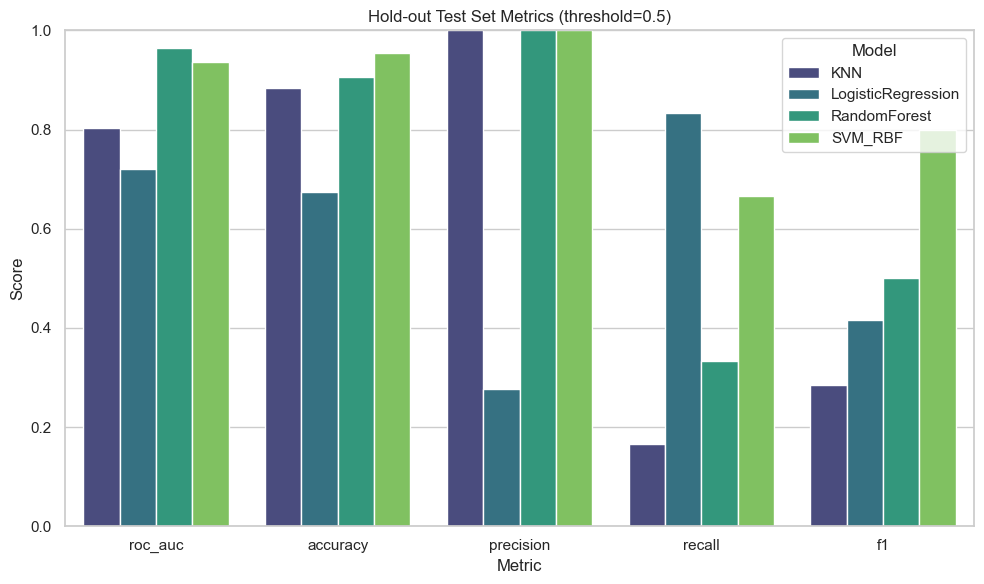

In [45]:
# Metric comparison bar plot (computed from hold-out test set)
holdout_metrics = []
for name, preds in val_preds.items():
    probs = val_probas[name]
    holdout_metrics.append({
        'model': name,
        'roc_auc': roc_auc_score(y_val, probs),
        'accuracy': accuracy_score(y_val, preds),
        'precision': precision_score(y_val, preds, zero_division=0),
        'recall': recall_score(y_val, preds),
        'f1': f1_score(y_val, preds)
    })

plot_df = pd.DataFrame(holdout_metrics).melt(
    id_vars='model', 
    var_name='metric', 
    value_name='score'
)

plt.figure(figsize=(10, 6))
sns.barplot(data=plot_df, x='metric', y='score', hue='model', palette='viridis')
plt.title('Hold-out Test Set Metrics (threshold=0.5)')
plt.ylabel('Score')
plt.xlabel('Metric')
plt.ylim(0, 1)
plt.legend(title='Model')
plt.tight_layout()
plt.show()